In [1]:
import torch
import time
import matplotlib.pyplot as plt
import numpy as np

In [2]:
GPU_SPECS = {
  "name": "NVIDIA T4",
  "peak_gflops": 8100, # FP32 Theoretical Peak
  "peak_bandwidth": 320, # GB/s Theoretical Peak
}

In [3]:
def benchmark_op(op_name, func, args, num_runs=100, warmup=10):
  for _ in range(warmup):
    func(*args)

  torch.cuda.synchronize()

  start_event = torch.cuda.Event(enable_timing=True)
  end_event = torch.cuda.Event(enable_timing=True)

  start_event.record()
  for _ in range(num_runs):
    func(*args)

  torch.cuda.synchronize()
  end_event.record()

  return start_event.elapsed_time(end_event) / num_runs

In [7]:
def run_benchmarks():
    if not torch.cuda.is_available():
        print("CUDA is not available. This benchmark requires a GPU.")
        return []

    device = torch.device("cuda")
    print(f"Running on: {torch.cuda.get_device_name(0)}")

    results = []

    # --- KERNEL 1: Matrix Multiplication (Compute Bound) ---
    # N x N matrix multiply. High Arithmetic Intensity.
    # FLOPs: 2 * N^3
    # Bytes: 3 * N^2 * 4 (Reading A, B, Writing C, float32 is 4 bytes)
    N = 4096
    A = torch.randn(N, N, device=device, dtype=torch.float32)
    B = torch.randn(N, N, device=device, dtype=torch.float32)

    def matmul_op(a, b):
        return torch.matmul(a, b)

    avg_time_ms = benchmark_op("MatMul", matmul_op, (A, B))

    flops = 2 * N**3
    bytes_accessed = 3 * (N**2) * 4
    intensity = flops / bytes_accessed
    achieved_gflops = (flops / (avg_time_ms * 1e-3)) / 1e9

    print(f"[MatMul] Intensity: {intensity:.2f} FLOPs/Byte | Speed: {achieved_gflops:.2f} GFLOPS")
    results.append({"name": "MatMul (Torch)", "intensity": intensity, "gflops": achieved_gflops})

    # --- KERNEL 2: Vector Add (Memory Bound) ---
    # Element-wise addition. Low Arithmetic Intensity.
    # FLOPs: N (1 add per element)
    # Bytes: 3 * N * 4 (Read A, Read B, Write C)
    size = 1024 * 1024 * 64  # 64 Million elements
    X = torch.randn(size, device=device, dtype=torch.float32)
    Y = torch.randn(size, device=device, dtype=torch.float32)

    def add_op(x, y):
        return x + y

    avg_time_ms_add = benchmark_op("Add", add_op, (X, Y))

    flops_add = size
    bytes_add = 3 * size * 4
    intensity_add = flops_add / bytes_add
    achieved_gflops_add = (flops_add / (avg_time_ms_add * 1e-3)) / 1e9

    print(f"[VecAdd] Intensity: {intensity_add:.2f} FLOPs/Byte | Speed: {achieved_gflops_add:.2f} GFLOPS")
    results.append({"name": "VectorAdd (Torch)", "intensity": intensity_add, "gflops": achieved_gflops_add})

    return results

In [8]:
def plot_roofline(results):
    if not results:
        print("No results to plot.")
        return

    peak_gflops = GPU_SPECS["peak_gflops"]
    peak_bw = GPU_SPECS["peak_bandwidth"]

    # X-axis: Arithmetic Intensity (Log scale)
    x = np.logspace(-2, 3, 100)  # 0.01 to 1000

    # Roofline Formula: min(Peak Compute, Bandwidth * Intensity)
    y = np.minimum(peak_gflops, peak_bw * x)

    plt.figure(figsize=(10, 6))

    # Plot the Rooflines
    plt.loglog(x, y, 'r-', label=f"Theoretical Peak ({GPU_SPECS['name']})")
    plt.axhline(y=peak_gflops, color='gray', linestyle='--', label="Peak Compute")

    # Plot Bandwidth Slope
    # Helper line to visualize bandwidth limit clearer
    y_bw = peak_bw * x
    plt.loglog(x, y_bw, 'g--', alpha=0.5, label="Peak Bandwidth")

    # Plot our Benchmarks
    for res in results:
        plt.plot(res['intensity'], res['gflops'], 'bo', markersize=10)
        plt.text(res['intensity'] * 1.1, res['gflops'], res['name'], fontsize=12, color='blue')

    plt.xlabel("Arithmetic Intensity (FLOPs/Byte)")
    plt.ylabel("Performance (GFLOPS)")
    plt.title(f"Roofline Model: {GPU_SPECS['name']}")
    plt.grid(True, which="both", ls="-")
    plt.legend()

    output_file = "benchmark_plot.png"
    plt.savefig(output_file)
    print(f"Plot saved to {output_file}")
    plt.show()

Running on: Tesla T4
[MatMul] Intensity: 682.67 FLOPs/Byte | Speed: 4374.86 GFLOPS
[VecAdd] Intensity: 0.08 FLOPs/Byte | Speed: 19.91 GFLOPS
Plot saved to benchmark_plot.png


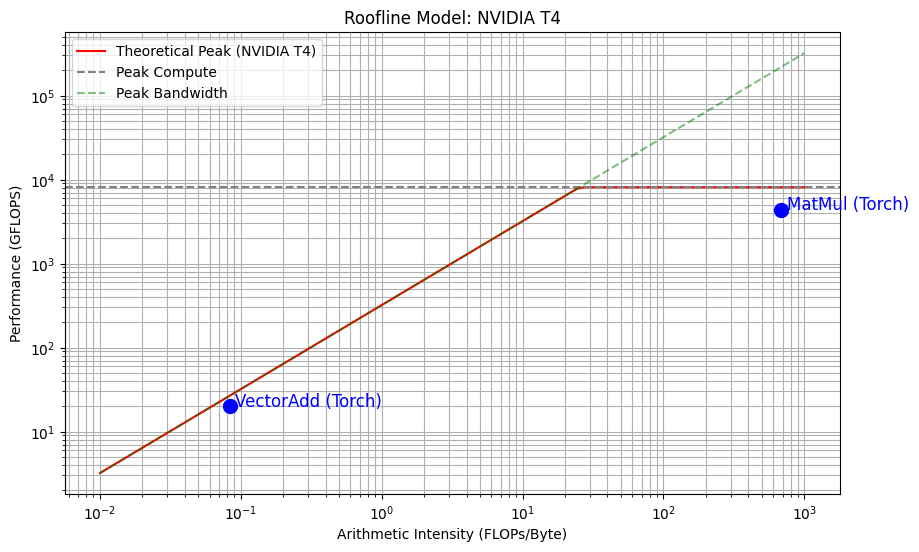

In [9]:
if __name__ == "__main__":
    data = run_benchmarks()
    plot_roofline(data)